In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#import dataset
comp_df_input = pd.read_csv("Company_Data.csv")
comp_df_input.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## EDA

In [3]:
#Creating categorical target column based on the sales, if sales > 6 then it cosidered as high, remaining values as low
comp_df = comp_df_input.copy()
comp_df ["Sales"] = ["low" if Sales <= 6 else "high" 
                                 for Sales in comp_df["Sales"]] 

In [4]:
# Check for any null values
comp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sales        400 non-null    object
 1   CompPrice    400 non-null    int64 
 2   Income       400 non-null    int64 
 3   Advertising  400 non-null    int64 
 4   Population   400 non-null    int64 
 5   Price        400 non-null    int64 
 6   ShelveLoc    400 non-null    object
 7   Age          400 non-null    int64 
 8   Education    400 non-null    int64 
 9   Urban        400 non-null    object
 10  US           400 non-null    object
dtypes: int64(7), object(4)
memory usage: 34.5+ KB


In [5]:
#check for duplicate rows
comp_df[comp_df.duplicated()]

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US


In [6]:
#Descriptive statitics
comp_df.describe()

,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


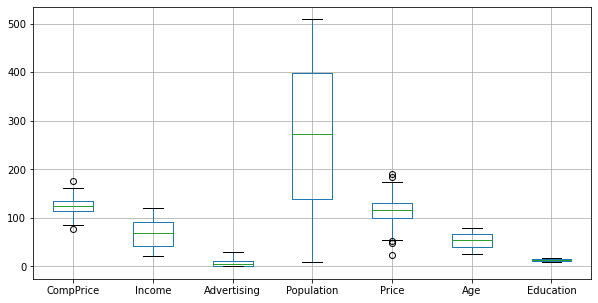

In [7]:
#Boxplot
comp_df.boxplot(figsize=(10,5));

In [8]:
#Deleteing univariate outliers
comp_df_eda = comp_df.drop(comp_df[comp_df["CompPrice"] > 170].index, axis=0)
comp_df_eda = comp_df_eda.drop(comp_df_eda[comp_df_eda["Price"] > 180].index, axis=0)
comp_df_eda = comp_df_eda.drop(comp_df_eda[comp_df_eda["Price"] < 25].index, axis=0)
comp_df_eda.reset_index(inplace=True, drop=True)

In [9]:
#Checking for outliers using Isolation forest, lets consider contamination level is 0.01
from sklearn.ensemble import IsolationForest

isf = IsolationForest(n_estimators=100,random_state=0,contamination=0.01)
y_isf = isf.fit_predict(pd.get_dummies(comp_df_eda))
outlier_index = np.where(y_isf==-1)
#Outlier index in dataframe
outlier_index

(array([ 74, 128, 225, 281], dtype=int64),)

In [10]:
#Remove the outliers
comp_df_final = comp_df_eda.drop(index=outlier_index[0], axis=0)
comp_df_final.reset_index(inplace=True, drop=True)

In [11]:
#Independet variable set 
x = pd.get_dummies(comp_df_final.iloc[:,1:])

In [12]:
# Dependent variable
y = LabelEncoder().fit_transform(comp_df_final["Sales"])

## Model

In [13]:
#find best parameters using gridsearch 
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(random_state=1)
kfold = KFold(n_splits=5)
para_grid = [{"n_estimators":[100,150,200,300,500],"criterion":["gini","entropy"],"max_depth":[3,4,5]}]
gsv = GridSearchCV(classifier,para_grid, cv=kfold)
gsv.fit(x,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=1),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 4, 5],
                          'n_estimators': [100, 150, 200, 300, 500]}])

In [14]:
#Best parameters
gsv.best_params_, gsv.best_score_

({'criterion': 'gini', 'max_depth': 5, 'n_estimators': 500}, 0.818889970788705)

In [15]:
#Model 
classifier_final = RandomForestClassifier(n_estimators=100, criterion="gini",max_depth=5,random_state=1)
classifier_final.fit(x,y)
results = cross_val_score(classifier_final,x,y,cv=kfold)

In [16]:
#Model Score
round(results.mean(),3)

0.809